# Importing Libraries

In [1]:
# Basic packages
import pandas as pd
import numpy as np
import scipy as spy
import seaborn as sns
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

---

# Data ingestion

In [3]:
# Load dataset
data = pd.read_csv("InsuranceBusinessStats.csv")

---

**Convert Pandas Objects to Category type**

In [4]:
# Convert variables with "object" type to "category" type
for i in data.columns:
    if data[i].dtypes == "object":
        data[i] = data[i].astype("category") 

# Confirm if there no variables with "object" type
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1338 non-null   int64   
 1   sex       1338 non-null   category
 2   bmi       1338 non-null   float64 
 3   children  1338 non-null   int64   
 4   smoker    1338 non-null   category
 5   region    1338 non-null   category
 6   charges   1338 non-null   float64 
dtypes: category(3), float64(2), int64(2)
memory usage: 46.3 KB


---

**Duplicate row check function**

In [5]:
def df_duplicate_removal(data):
    """
    This function checks if there are any duplicated rows in the dataframe.
    If any, it displays the rows, keep the first occurence and drops the 
    duplicates.

    The new dataframe shape is calculated and returned
    """
    # Check if duplicated rows exist
    if any(data.duplicated() == True):
        print("The following is/are the duplicated row(s) in the dataframe")
        # Displays the duplicated row(s)
        display(data[data.duplicated() == True])
        # Drops the duplicates inplace while keeping the first occurence
        data.drop_duplicates(keep="first", inplace=True)

        # Check and returns the shape of the new dataframe
        new_df_shape = data.shape
        n_rows = new_df_shape[0]
        n_cols = new_df_shape[1]
        print(
            f"The new dataframe  consists of '{n_rows}' rows and '{n_cols}' columns")
    else:
        print("There is/are no duplicated row(s) in the dataframe")

In [6]:
df_duplicate_removal(data)

The following is/are the duplicated row(s) in the dataframe


,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


The new dataframe  consists of '1337' rows and '7' columns


---

**Create independent sub-lists to separate Numerical and Categorical variables for EDA**

In [7]:
# Select numeric variables
numeric_columns = data.select_dtypes(include=['int', 'float']).columns.tolist()
# Select categorical variables
categorical_columns = data.select_dtypes(include=['category']).columns.tolist()

---

---

# Feature Engineering

Binning Continuous data into Categorical Data

**Categorizing Age**

Let's categorize the **AGE** into groups for analysis
Let's split age into the following groups:
1. Young Adults (ages 18-34)
2. Middle Age (ages 35-54)
3. Senior Adults (ages 55-64)

In [8]:
# Define the age bins and labels
age_bins = [18, 35, 55, 64]
age_label = ["Young Adults", "Middle Aged", "Senior Adults"]
# Create a new column with age categories
data['AgeGroup'] = pd.cut(
    data['age'], bins=age_bins, include_lowest=True, right=False, labels=age_label)

**Categorizing BMI**

Let's categorize the **BMI** into groups for analysis
Let's split bmi into the following groups:
1. Under Weight (bmi < 18.5)
2. Ideal BMI (bmi 18.5-24.9)
3. Over Weight (bmi 25-29.9)
4. Obese (bmi > 30)

In [9]:
# Define the age bins and labels
bmi_bins = [0, 18.5, 25, 30, 99]
bmi_label = ["Under Weight", "Ideal BMI", "Over Weight", "Obese"]
# Create a new column with age categories
data['bmi_groups'] = pd.cut(
    data.bmi, bmi_bins, include_lowest=True, right=False, labels=bmi_label)

---

# Statistical Testing

## Do smokers file higher insurance charges compared to non-smokers?

To achieve this we shall establish the following *hypotheses* comparing **smoker charges** and **non-smoker charges**:

 $H_o$ $:$ $\text{There is NO significant difference between Smoker Charges and Non-Smoker Charges}$ 

 $H_a$ $:$ $\text{There is a significant difference between Smoker Charges and Non-Smoker Charges}$

With a level of significance: $\alpha = 0.05$

The `smoker` series consists of **yes** and **no**  values to indicate *smoker* and *non-smoker*.  

To obtain the `charges` of the *smoker* and *non-smoker*, we shall split the `smoker` series by the **yes** and **no** values and retrieve the corresponding `charges`.

This will result in two separate numerical samples `smoker charges` and `non-smoker charges`

**Let's do Pandas `groupby` and `describe` to get a view of the data**

In [10]:
data.groupby('smoker')['charges'].describe()

,count,mean,std,min,25%,50%,75%,max
smoker,,,,,,,,
no,1063.0,8440.660307,5992.973800,1121.8739,3988.883500,7345.72660,11363.019100,36910.60803
yes,274.0,32050.231832,11541.547176,12829.4551,20826.244213,34456.34845,41019.207275,63770.42801


Visually we can observe the following:
1. There are at least **3** times as many `non-smokers` as there are `smokers`
2. The mean of `smoker charges` is at least **3 times that of the mean of `non-smoker charges`.

**Now let's split the charges series into smokers and non-smokers**

In [11]:
smoker_charges = data[data["smoker"]=="yes"]["charges"]
non_smoker_charges = data[data["smoker"]=="no"]["charges"]

Let's visualize the distribution of both samples

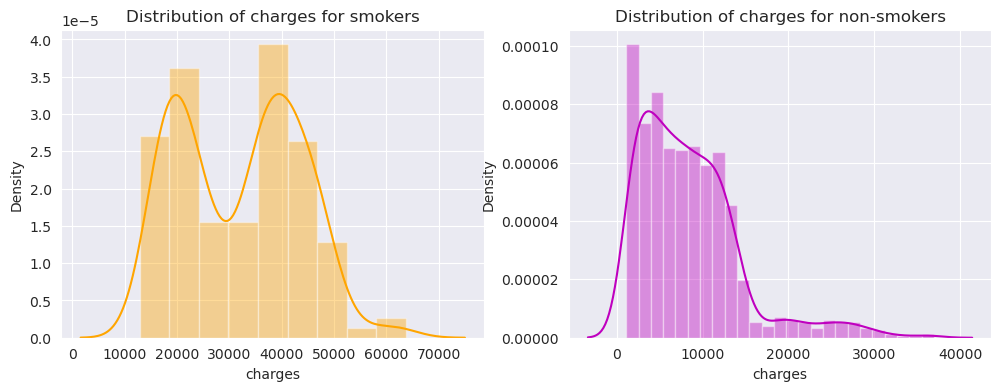

In [12]:
fig = plt.figure(figsize=(12, 4))
sns.set_style("darkgrid")
ax = fig.add_subplot(121)
sns.distplot(smoker_charges, color='orange',).set_title(
    'Distribution of charges for smokers')
ax = fig.add_subplot(122)
sns.distplot(non_smoker_charges, color='m').set_title(
    'Distribution of charges for non-smokers')
sns.reset_defaults()

**Observation:** 

* The **Smoker Charges** distribution appear to be *bi-modal* while the **Non-smoker Charges** appear to be *right skewed*.

In order to evaluate the hypotheses, let conduct an analysis to see which testing procedure will be suitable.

Lets checks its validity for **Parametric testing**.  
The following assumptions need to be fulfilled before administering any parametric tests.
1. Independence
2. Normality
3. Samples have equal variances

<span style="font-family: Arial; font-weight:bold;color:blue;">**Test for Independence**

Since the `smoker_charges` and `non_smoker_charges` both come from independent portions of the `charges` data, they can be assumed as independent groups.

<span style="font-family: Arial; font-weight:bold;color:blue;">**Test for Normality**

To conduct a test for normality we use the `Shapiro test`.

It evaluates normality by comparing the data's distribution to the hypothesized normal distribution by assuming the observations in each sample are independent and identically distributed.

$H_o$ $:$ $\text{Normal distribution}$  

$H_a$ $:$ $\text{Not a Normal distribution}$

With a level of significance: $\alpha = 0.05$

Import `shapiro` function from scipy

In [13]:
from scipy.stats import shapiro

`Shapiro test` for **smoker_charges**

In [14]:
stat, p = shapiro(smoker_charges)
print(" The Shapiro test p-value is {}".format(p))
if p > 0.05:
    print('The smoker_charges sample is approximately Normal as Shapiro p-value > 0.05')
else:
    print('The smoker_charges sample distribution is not Normal as Shapiro p-value < 0.05')

 The Shapiro test p-value is 3.6255991542333277e-09
The smoker_charges sample distribution is not Normal as Shapiro p-value < 0.05


`Shapiro test` for **non_smoker_charges**

In [15]:
stat, p = shapiro(non_smoker_charges)
print(" The Shapiro test p-value is {}".format(p))
if p > 0.05:
    print('The non_smoker_charges sample is approximately Normal as Shapiro p-value > 0.05')
else:
    print('The non_smoker_charges sample distribution is not Normal as Shapiro p-value < 0.05')

 The Shapiro test p-value is 1.503623581761669e-28
The non_smoker_charges sample distribution is not Normal as Shapiro p-value < 0.05


Based on the `Shapiro test` for each variable, we get a **p-value <0.05** and **Reject the Null Hypothesis**. 

<font color='red'> Therefore we can conclude that the **smoker_charges** and **non_smoker_charges** distributions both indicate **non-normality** at the **5% significance level** 

<span style="font-family: Arial; font-weight:bold;color:blue;">**Test for Equal Variances**

We shall conduct the `Levene` test for equal variances across series.

To conduct a test for equal variances we shall use the `Levene test`.

It tests the null hypothesis that all input samples are from populations with equal variances

$H_o$ $:$ $\text{The sample variances of both samples are equal}$ 

$H_a$ $:$ $\text{The sample variances of both samples are NOT equal}$

With a level of significance: $\alpha = 0.05$

Import `Levene` function from scipy

In [16]:
from scipy.stats import levene

In [17]:
stat, p = levene(smoker_charges,non_smoker_charges)
print(" The Levene test p-value is {}".format(p))
if p > 0.05:
    print('The smoker_charges & non_smoker_charges samples DO have equal variances as Levene p-value > 0.05')
else:
    print('The smoker_charges & non_smoker_charges samples DO NOT have equal variances as Levene p-value < 0.05')

 The Levene test p-value is 1.670117565125241e-66
The smoker_charges & non_smoker_charges samples DO NOT have equal variances as Levene p-value < 0.05


Based on the `Levene test`, we get a **p-value <0.05** and **Reject the Null Hypothesis**. 

<font color='red'> Therefore we can conclude that the **smoker_charges** and **non_smoker_charges** samples **do not** have equal variances at the **5% significance level**

Since the **smoker_charges** and **non_smoker_charges** samples do not fulfill the **Normality and Equal Variances** of the assumptions for **Parametric tests**.  

We need to progress by conducting a **Non-Parametric test**

<span style="font-family: Arial; font-weight:bold;color:blue;">**Non-Parametric Test**

Let's conduct the **Mann-Whitney U Test** as there are 2 samples.

Tests whether the distributions of two independent samples are equal or not.

$H_o$ $:$ $\text{Distributions of both samples are equal}$  

$H_a$ $:$ $\text{Distributions of both samples are not equal}$

With a level of significance: $\alpha = 0.05$

Import `Mann-Whitney U` function from scipy

In [18]:
from scipy.stats import mannwhitneyu

In [19]:
stat, p = mannwhitneyu(smoker_charges,non_smoker_charges)
print(" The Mann-Whitney U test p-value is {}".format(p))
if p > 0.05:
    print('The smoker_charges & non_smoker_charges distributions are equal as p-value > 0.05')
else:
    print('The smoker_charges & non_smoker_charges distributions are NOT equal as p-value < 0.05')

 The Mann-Whitney U test p-value is 5.74701188239214e-130
The smoker_charges & non_smoker_charges distributions are NOT equal as p-value < 0.05


Based on the Mann-Whitney U test, we get a **p-value <0.05** and **Reject the Null Hypothesis**. 

Therefore we can conclude that the **smoker_charges** and **non_smoker_charges** distributions are **not** equal at a **5% significance level**.

<font color='red'>Since the *Mann-Whitney U Test* Null Hypothesis was *rejected* for *pvalue <.0001*, we can state that with *99.99% confidence*, the **smokers charges differ significantly to that of the non-smokers charges**

For completeness let's still conduct a **Parametric test** to compare its result.

<span style="font-family: Arial; font-weight:bold;color:blue;">**Parametric Test**

Let's conduct the **two sample Student's t test**

Tests whether the sample means of two independent samples are equal or not.

$H_o$ $:$ $\text{Sample means of both samples are equal}$  

$H_a$ $:$ $\text{Sample means of both samples are not equal}$

With a level of significance: $\alpha = 0.05$

Import `ttest_ind` function from scipy

In [20]:
from scipy.stats import ttest_ind

In [21]:
t_stat, p =ttest_ind(smoker_charges, non_smoker_charges)
print(" The two sample Student's t test p-value is {}".format(p))
if p > 0.05:
    print('The smoker_charges & non_smoker_charges sample means are equal as p-value > .05')
else:
    print('The smoker_charges & non_smoker_charges sample means are NOT equal as p-value < .05')

 The two sample Student's t test p-value is 1.4067220949376498e-282
The smoker_charges & non_smoker_charges sample means are NOT equal as p-value < .05


Based on the **two sample Student's t test**, we get a **p-value <.05** and **Reject the Null Hypothesis**.

Therefore we can conclude that the`smoker_charges` and `non_smoker_charges` sample means are **not** equal at a **5% significance level**. 
    
<font color='red'>Since the *two sample Student's t test* Null Hypothesis was *rejected* for *pvalue <.0001*, we can state that with *99.99% confidence*, the **smokers charges differ significantly to that of the non-smokers charges**

---

## Does the BMI of Females differ from the BMI of Males?

To achieve this we shall establish following hypotheses comparing `Female BMI` and `Male BMI`:

$H_o$ $:$ $\text{The BMI of the Female customers does NOT significantly differ from the BMI of the Male customers}$

$H_a$ $:$ $\text{The BMI of the Female customers does significantly differ from the BMI of the Male customers}$

With a level of significance: $\alpha = 0.05$

The `sex` series consists of **male** and **female**  values.

We shall split the `sex` series by the **male** and **female** values and retrieve the corresponding `bmi`.

This will result in two separate numerical samples `male_bmi` and `female_bmi`

**Let's do Pandas `groupby` and `describe` to get a view of the data**

In [22]:
data.groupby('sex')['bmi'].describe()

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
female,662.0,30.377749,6.046023,16.815,26.125,30.1075,34.31375,48.07
male,675.0,30.943652,6.144973,15.960,26.410,30.6900,35.02500,53.13


Visually we can observe the following:
1. There are close to equal quantity of males and females in the dataset.

2. THe mean bmi of male and female customer are very close to equal in the dataset.


**Now let's split the bmi series into male_bmi and female_bmi**

In [23]:
male_bmi = data[data["sex"]=="male"]["bmi"]
female_bmi = data[data["sex"]=="female"]["bmi"]

Let's visualize the distribution of both samples

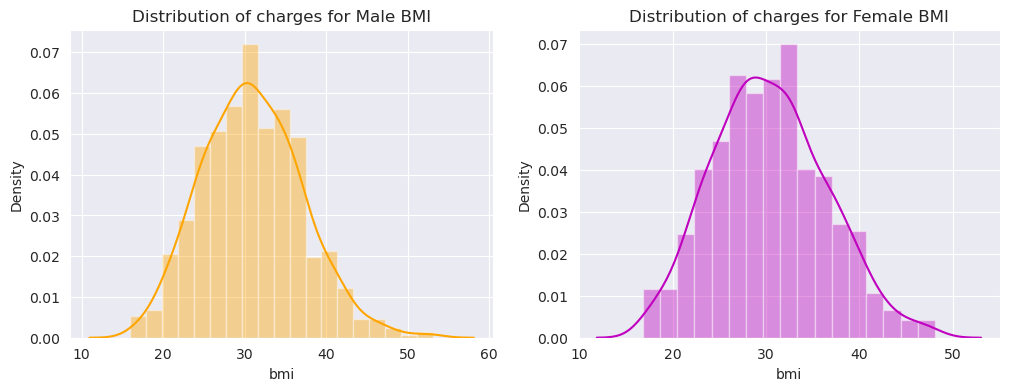

In [24]:
fig = plt.figure(figsize=(12, 4))
sns.set_style("darkgrid")
ax = fig.add_subplot(121)
sns.distplot(male_bmi, color='orange',).set_title(
    'Distribution of charges for Male BMI')
ax = fig.add_subplot(122)
sns.distplot(female_bmi, color='m').set_title(
    'Distribution of charges for Female BMI')
sns.reset_defaults()
plt.show()

**Observation:** 

* Visually the distribution of the **Male BMI** and **Female BMI** both appear to be **normal**

In order to evaluate the hypotheses, let conduct an analysis to see which testing procedure will be suitable.

Lets checks its validity for **Parametric testing**.  
The following assumptions need to be fulfilled before administering any parametric tests.
1. Independence
2. Normality
3. Samples have equal variances

<span style="font-family: Arial; font-weight:bold;color:blue;">**Test for Independence**

Since the `male_bmi` and `female_bmi` both come from independent portions of the `bmi` data, they can be assumed as independent groups.

<span style="font-family: Arial; font-weight:bold;color:blue;">**Test for Normality**

We shall conduct the Shapiro test for each series to determine its fit to normality

`Shapiro test` for **male_bmi**

In [25]:
stat, p = shapiro(male_bmi)
print(" The Shapiro test p-value is {}".format(p))
if p > 0.05:
    print('The male_bmi sample is approximately Normal as Shapiro p-value > 0.05')
else:
    print('The female_bmi sample distribution is NOT Normal as Shapiro p-value < 0.05')

 The Shapiro test p-value is 0.003164957743138075
The female_bmi sample distribution is NOT Normal as Shapiro p-value < 0.05


`Shapiro test` for **female_bmi**

In [26]:
stat, p = shapiro(female_bmi)
print(" The Shapiro test p-value is {}".format(p))
if p > 0.05:
    print('The male_bmi sample is approximately Normal as Shapiro p-value > 0.05')
else:
    print('The female_bmi sample distribution is not Normal as Shapiro p-value < 0.05')

 The Shapiro test p-value is 0.003545489627867937
The female_bmi sample distribution is not Normal as Shapiro p-value < 0.05


Based on the `Shapiro test` for each variable, we get a **p-value <0.05** and **Reject the Null Hypothesis**. 

<font color='red'> Therefore we can conclude that the **male_bmi** and **female_bmi** both indicate **non-normality** at the *5% significance level* 

<span style="font-family: Arial; font-weight:bold;color:blue;">**Test for Equal Variances**

We shall conduct the `Levene` test for equal variances across series.

`Levene` test for `male_bmi` and `female_bmi` series.

In [27]:
stat, p = levene(male_bmi,female_bmi)
print(" The Levene test p-value is {}".format(p))
if p > 0.05:
    print('The male_bmi & female_bmi samples DO have equal variances as Levene p-value > 0.05')
else:
    print('The male_bmi & female_bmi samples DO NOT have equal variances as Levene p-value < 0.05')

 The Levene test p-value is 0.9216570820140155
The male_bmi & female_bmi samples DO have equal variances as Levene p-value > 0.05


Based on the `Levene test`, we get a **p-value >0.05** and **Fail to Reject the Null Hypothesis**. 

<font color='red'>Therefore we can conclude that the **male_bmi** and **female_bmi** samples **do** have equal variances at the *5% significance level*

Since the *Shapiro test* indicated *non-normality* at a *5% significance level* but the *Levene test* also indicated that the *variances are equal* at the same significance level, it is **safe** to proceed with **Parametric tests** to determine validity of the initial hypotheses.

<span style="font-family: Arial; font-weight:bold;color:blue;">**Parametric Test**

Let's conduct the **two sample Student's t test**

In [28]:
t_stat, p =ttest_ind(male_bmi, female_bmi)
print(" The two sample Student's t test p-value is {}".format(p))
if p > 0.05:
    print('The male_bmi & female_bmi sample means are equal as p-value > 0.05')
else:
    print('The male_bmi & female_bmi sample means are NOT equal as p-value < 0.05')

 The two sample Student's t test p-value is 0.08991704324931137
The male_bmi & female_bmi sample means are equal as p-value > 0.05


Based on the two sample Student's t test, we get a **p-value >0.05** and **Fail to Reject the Null Hypothesis**. 

Therefore we can conclude that the **male_bmi** and **female_bmi** sample means **are** equal at a **95% confidence level**

<font color='red'>Since the *two sample Student's t test* Null Hypothesis was *failed to be rejected* at a *pvalue >0.05*, we can state that with *95% confidence*, the **BMI of females customers does NOT differ significantly from the BMI of males**

---

## Is the proportion of smokers significantly different across different regions?

To achieve this we shall establish following hypotheses comparing `smoker` and `region`:

$H_o$ $:$ $\text{There is NO significant difference in the proportion of smokers in different regionn, i.e, Smoker and Region are independent}$

$H_a$ $:$ $\text{There is a significant difference in the proportion of smokers in different regions, i.e., Smoker and Region are not independent}$

With a level of significance: $\alpha = 0.05$

The `smoker` series consists of **yes** and **no**  values to indicate *smoker* and *non-smoker*.  

The `region` series consists of `southwest`, `southeast`, `northwest`, `northeast` values to indicate the US geographical area where the customers belong.

The `smoker` and `region` are both *categorical* variables.

To visualize the frequency of *smoker* and *non-smoker* across each region, the frequency or count will need to equated.

**Let's do Pandas `crosstab` to create a simple cross tabulation (contingency table) or frequency table of the `smoker` and `region` variables.**

In [29]:
contingency_table = pd.crosstab(data['smoker'], data['region'])
contingency_table

region,northeast,northwest,southeast,southwest
smoker,,,,
no,257,266,273,267
yes,67,58,91,58


We shall assume the `smoker` and `region` are both independent as the variables were collected independently of each other.

Therefore in order to evaluate the hypotheses, let's conduct the **Chi-square test of independence**.

The **Chi-square test of independence** evaluates dependence between categorical variables.

$H_o$ $:$ $\text{Variables are independent}$  

$H_a$ $:$ $\text{Variables are not independent}$

With a level of significance: $\alpha = 0.05$

This will generate the chi-square statistic, p-value, degrees of freedom and expected frequencies for the hypothesis test of independence of the observed frequencies in the contingency table.

Import `chi2_contingency` function from scipy

In [30]:
from scipy.stats import chi2_contingency

`Chi-square test of independence` of variables in a contingency table.

In [31]:
chi2_stat, p, dof, expected = chi2_contingency(contingency_table)

In [32]:
print("The Chi_square test Statistic = {:.4f}".format(chi2_stat))
print("The Chi_square test p_value = {:.4f}".format(p))
print("The Chi_square test degrees of freedom= {}".format(dof))

The Chi_square test Statistic = 7.2779
The Chi_square test p_value = 0.0635
The Chi_square test degrees of freedom= 3


In [33]:
print("The Chi_square test expected frequencies")
expected

The Chi_square test expected frequencies


array([[257.60059835, 257.60059835, 289.40314136, 258.39566193],
       [ 66.39940165,  66.39940165,  74.59685864,  66.60433807]])

We need to calculate the **Critical Chi-Square Statistic** to determine if we should **Reject** or **Fail to Reject** the `Null Hypothesis`

We obtain the **Critical Chi-Square Statistic** using the *level of significance* and *degrees of freedom*

Import `chi2` function from scipy

In [34]:
from scipy.stats import chi2

Level of significance used in Hypotheses

In [35]:
alpha = 0.05

The **Critical Chi-Square Statistic**  is calculated from **chi2 percentage point function**

In [36]:
critical_chi2 = chi2.ppf((1-alpha), dof)

In [37]:
print("The Critical Chi_square test Statistic = {:.4f}".format(critical_chi2))

The Critical Chi_square test Statistic = 7.8147


Compare the **Chi2-Square Statistic** to the **Critical Chi2-Square Statistic**

In [38]:
if abs(chi2_stat) >= critical_chi2:
    print("Chi2-Square Statistic >= Critical Chi2-Square Statistic")
    print('Reject the Null Hypothesis')
    print("The Smoker and Region variables are not independent")
    print("There is a significant difference in proportions of Smoker and across different Regions")
        
else:
    print("Chi2-Square Statistic < Critical Chi2-Square Statistic")
    print('Fail to Reject the Null Hypothesis')
    print("The Smoker and Region variables are independent")
    print("There is no significant difference in proportions of Smoker and across different Regions")    

Chi2-Square Statistic < Critical Chi2-Square Statistic
Fail to Reject the Null Hypothesis
The Smoker and Region variables are independent
There is no significant difference in proportions of Smoker and across different Regions


Compare the **p_value** to the **level of significance**

In [39]:
if p <= alpha:
    print("p_value < alpha")
    print('Reject the Null Hypothesis')
    print("The Smoker and Region variables are not independent")
    print("There is a significant difference in proportions of Smoker and across different Regions")
    
else:
    print("p_value > alpha")
    print('Fail to Reject the Null Hypothesis')
    print("The Smoker and Region variables are independent")
    print("There is no significant difference in proportions of Smoker and across different Regions") 

p_value > alpha
Fail to Reject the Null Hypothesis
The Smoker and Region variables are independent
There is no significant difference in proportions of Smoker and across different Regions


Based on the Chi-square test for independence, we get a **p-value >0.05** & **Chi2-Sq Stat < Critical Chi2-Sq Stat**

Therefore we **Fail to Reject the Null Hypothesis** which indicates that  **smoker** and **region** are independent.

<font color='red'>Thus we can state that at a **95% confidence level**, there is **NO** significant difference in the proportion of **smokers** in across different **regions** 

---

## Is the mean BMI of women with no children, one child and two children the same?

To do this we shall extract the `females` that who have at most 2 `children` on their policy.

In [40]:
female_child_2max = data[data['sex']=="female"][data['children']<=2]

Let's visualize the distribution of the **Female BMI** up to 2 children.

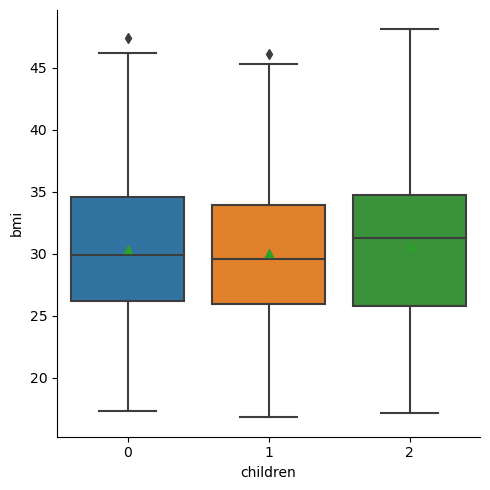

In [41]:
sns.catplot(y='bmi', x='children', kind="box", data=female_child_2max, showmeans=True)
plt.show();

**Observations:**
* The **female BMI** is identically distributed with customers having up to 2 children/dependents on their policy


**Now let's prove it statistically.**

Let's establish the following *hypotheses* comparing the **mean BMI of women** with **no children**, **one child** and **two children**: 

$H_o$ $:$ $\text{The sample means are equal}$

$H_a$ $:$ $\text{At least one of the sample means are not equal}$

With a level of significance: $\alpha = 0.05$

Let's generate the samples

**Women BMI** with **no children**

In [42]:
child_0 = female_child_2max[female_child_2max["children"]==0]["bmi"]

**Women BMI** with **one child**

In [43]:
child_1 = female_child_2max[female_child_2max["children"]==1]["bmi"]

**Women BMI** with **two children**

In [44]:
child_2 = female_child_2max[female_child_2max["children"]==2]["bmi"]

In order to evaluate the sample means we will need to conduct the **One Way Analysis of Variance (ANOVA)**.

The following assumptions need to be fulfilled before administering **One Way Analysis of Variance (ANOVA)** tests.
1. Independence
2. Normality
3. Samples have equal variances

<span style="font-family: Arial; font-weight:bold;color:blue;">**Test for Independence**

Since the samples all came from independent portions of the `BMI` data, they can be assumed as independent groups.

<span style="font-family: Arial; font-weight:bold;color:blue;">**Test for Normality**

We shall conduct the Shapiro test for each sample to determine its fit to normality

`Shapiro test` for **Women BMI** with **no children**

In [45]:
stat, p = shapiro(child_0)
print(" The Shapiro test p-value is {}".format(p))
if p > 0.05:
    print('The child_0 sample is approximately Normal as Shapiro p-value > 0.05')
else:
    print('The child_0 sample distribution is NOT Normal as Shapiro p-value < 0.05')

 The Shapiro test p-value is 0.037568025290966034
The child_0 sample distribution is NOT Normal as Shapiro p-value < 0.05


`Shapiro test` for **Women BMI** with **one child**

In [46]:
stat, p = shapiro(child_1)
print(" The Shapiro test p-value is {}".format(p))
if p > 0.05:
    print('The child_1 sample is approximately Normal as Shapiro p-value > 0.05')
else:
    print('The child_1 sample distribution is NOT Normal as Shapiro p-value < 0.05')

 The Shapiro test p-value is 0.5361911654472351
The child_1 sample is approximately Normal as Shapiro p-value > 0.05


`Shapiro test` for **Women BMI** with **two children**

In [47]:
stat, p = shapiro(child_2)
print(" The Shapiro test p-value is {}".format(p))
if p > 0.05:
    print('The child_2 sample is approximately Normal as Shapiro p-value > 0.05')
else:
    print('The child_2 sample distribution is NOT Normal as Shapiro p-value < 0.05')

 The Shapiro test p-value is 0.2596122622489929
The child_2 sample is approximately Normal as Shapiro p-value > 0.05


Based on the `Shapiro test` for each variable

* For **Women BMI** with **no children** we get a **p-value <0.05** and **Reject the Null Hypothesis**.   

  This implies **Women BMI** with **no children** is not normally distributed.

* For **Women BMI** with **one child** we get a **p-value >0.05** and **Fail to Reject the Null Hypothesis**.  

  This implies **Women BMI** with **one child** is normally distributed.

* For **Women BMI** with **two children** we get a **p-value >0.05** and **Fail to Reject the Null Hypothesis**. 

  This implies **Women BMI** with **two children** is normally distributed.

<font color='red'> Therefore we can conclude the following at the *5% significance level*:
* **Women BMI** with **no children** is not normally distributed
* **Women BMI** with **one child** is normally distributed.
* **Women BMI** with **two children** is normally distributed.

<span style="font-family: Arial; font-weight:bold;color:blue;">**Test for Equal Variances**

We shall conduct the `Levene` test for equal variances across series.

In [48]:
stat, p = levene(child_0,child_1,child_2)
print(" The Levene test p-value is {}".format(p))
if p > 0.05:
    print('The child_0, child_1, child_2 samples DO have equal variances as Levene p-value > 0.05')
else:
    print('The child_0, child_1, child_2 samples DO NOT have equal variances as Levene p-value < 0.05')

 The Levene test p-value is 0.3899432394522804
The child_0, child_1, child_2 samples DO have equal variances as Levene p-value > 0.05


Based on the `Levene test`, we get a **p-value >0.05** and **Fail to Reject the Null Hypothesis**.

<font color='red'>Therefore we can conclude at the *5% significance level* that the **Women BMI** with **no children**, **one child** and **two children** samples **do** have equal variances

Although, the *Shapiro test* indicated *non-normality* at a *5% significance level* for the **Women BMI** with **no children**, we shall still proceed to conduct the **One Way Analysis of Variance (ANOVA)** test as the assumptions of *Independence* and *Homogeniety of Variances* were upheld.

<span style="font-family: Arial; font-weight:bold;color:blue;">**One Way Analysis of Variance(ANOVA)**

Let's conduct the One Way ANOVA test:

Import `f_oneway` function from scipy

In [49]:
from scipy.stats import f_oneway

In [50]:
stat, p = f_oneway(child_0,child_1,child_2)
print(" The One Way Analysis of Variance test p-value is {}".format(p))
if p > 0.05:
    print('The mean BMI of women with no children, one child and two children are the same as p-value > .05')
else:
    print('At least one of the women BMI sample means with no children, one child and two children is NOT equal as p-value < .05')

 The One Way Analysis of Variance test p-value is 0.7158579926754841
The mean BMI of women with no children, one child and two children are the same as p-value > .05


Based on the **One Way Analysis of Variance (ANOVA)**, we get a **p-value >.05** and **Fail to Reject the Null Hypothesis**.

Therefore we can conclude that the mean BMI of women with no children, one child and two children are equal at a **5% significance level**. 
    
<font color='red'>Since the **One Way Analysis of Variance (ANOVA)** Null Hypothesis was *failed to be rejected* for *pvalue >0.05*, we can state that with *95% confidence*, mean BMI of women with no children, one child and two children is the same.

---